# Makemore 3

In [11]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [12]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [13]:
len(words)

32033

In [14]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [15]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [26]:
torch_seed = 2147483647

In [21]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(torch_seed) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g)
b2 = torch.randn(vocab_size,                      generator=g)

parameters = [C, W1, W2, b1, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [22]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  

      0/ 200000: 27.8817
  10000/ 200000: 2.9231
  20000/ 200000: 2.5788
  30000/ 200000: 2.8875
  40000/ 200000: 2.0839
  50000/ 200000: 2.4431
  60000/ 200000: 2.4559
  70000/ 200000: 2.1325
  80000/ 200000: 2.3324
  90000/ 200000: 2.3568
 100000/ 200000: 2.0748
 110000/ 200000: 2.4009
 120000/ 200000: 1.9218
 130000/ 200000: 2.4641
 140000/ 200000: 2.2747
 150000/ 200000: 2.1304
 160000/ 200000: 2.1510
 170000/ 200000: 1.7974
 180000/ 200000: 1.9913
 190000/ 200000: 1.8918


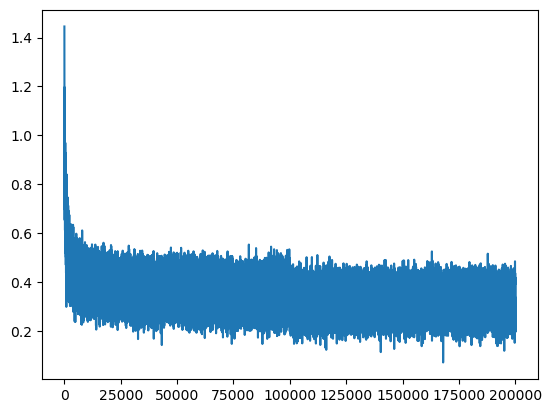

In [23]:
plt.plot(lossi)

In [24]:
@torch.no_grad() # decorator disable gradient tracking'
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concate into (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1) # (N, vocab_size)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
split_loss('train')
split_loss('val')

train 2.127152919769287
val 2.173154830932617


In [25]:
split_loss('train')

train 2.127152919769287


In [33]:
# sample from the model
g = torch.Generator().manual_seed(torch_seed)

for _ in range(20):
    out = []
    context = [0] * block_size # initalize with all ...
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])] # (1, block_size, embd)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h@ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
            
    print(''.join(itos[i] for i in out))

dexze.
moglynn.
rochi.
ahnes.
jimmana.
nella.
kama.
aristaithuelthariiotom.
moriella.
kinz.
teda.
kaley.
maside.
enkavion.
roslst.
hani.
gavtahlan.
kashra.
anell.
pynn.


In [29]:
context = [1, 2, 3, 4, 5]
context[1:]

[2, 3, 4, 5]

This completes our trigram model.

This will be the starting point for this notebook. There are multiple things wrong in this model configuration and we'll be fixing them one by one in this notebook.

## Initial loss

The inital loss is 27.8817 and it rapidly comes down to 1 or 2 and this initial loss is really high.

For this problem setup, There's 27 characters that could come next and at initialisation of model the probabality that any of these characters will come next is same which is uniform distribution.

And probabality for each character will be 1/27.0

In [35]:
# Is the intial loss we should get
-torch.tensor(1/27.0).log()

tensor(3.2958)

### Problem

At initialization, the model assigns varaible probablity instead of uniform probabality to all characters which it should. Probabality distributions are all messed up and for some characters it's really confident and for other characters not so much.

To sum up, Model is confidently wrong.

In [36]:
# 4-dimensional example of the issue
logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863))

Logits are uniform, so we get the correct loss. But what if logits varied.

In [37]:
# lucked out at initialisation and we get a really good loss
logits = torch.tensor([0.0, 0.0, 5.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([0.0066, 0.0066, 0.9802, 0.0066]), tensor(0.0200))

In [41]:
logits = torch.tensor([-3.0, 5.0, 0.0, 2.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([3.1741e-04, 9.4620e-01, 6.3754e-03, 4.7108e-02]), tensor(5.0553))

When the logits come out and have random extreme values, we record a high loss.

In [42]:
# with randn
logits = torch.randn(4)
probs = torch.softmax(logits, axis=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([-0.9826,  0.0343,  0.5874, -0.2068]),
 tensor([0.0931, 0.2573, 0.4474, 0.2022]),
 tensor(0.8043))

Since the values are near zero loss that comes out is good. but incresing logits by ten fold.

In [46]:
# with randn by tenfold
logits = torch.randn(4) * 10
probs = torch.softmax(logits, axis=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([ -4.3389, -16.4525,  -9.1865,  23.9195]),
 tensor([5.3398e-13, 2.9286e-18, 4.1903e-15, 1.0000e+00]),
 tensor(33.1060))

In [52]:
# with randn by hundredfold
logits = torch.randn(4) * 100
probs = torch.softmax(logits, axis=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([  -7.6815,  -12.4593,  -40.6270, -217.9730]),
 tensor([9.9166e-01, 8.3444e-03, 4.8787e-15, 0.0000e+00]),
 tensor(32.9539))

We get really bad losses for extreme logits.

This is not good and what we want logits to be roughly zero or equal(uniform) at initialisation.

Let's try to use wanddb track experiments.

In [8]:
import wandb

In [9]:
!set WANDB_DIR = "/Users/jayaprakashsivagami/Documents/Tech/ML/wandb"
!set WANDB_CACHE_DIR = "/Users/jayaprakashsivagami/Documents/Tech/ML/wandb/cache"
!set WANDB_CONFIG_DIR = "/Users/jayaprakashsivagami/Documents/Tech/ML/wandb/config"

In [10]:
wandb.login()

PermissionError: [Errno 13] Permission denied: '/Users/jayaprakashsivagami/.config/wandb'